In [44]:

import numpy as np

def LU_Decomposition(a, b):
    # replace Fortran ludcmp and lubksb
    # https://github.com/NCAR/GMET/blob/master/source/sp_regression/regression_routines.f90
    # ! Solve linear equation for x (Ax = b => x = bA^-1) using LU decomposition and back substitution.
    # ! Input:
    # !   X  = An m by n array.
    # !   TX = Precalculated transpose array of X, size n by m
    # !   Y  = An m-element vector containing the right-hand side of the linear system Ax = b.
    # ! Output:
    # !   B  = An n-element vector.

    deta = np.linalg.det(a)  # Compute the determinant of an array
    if deta == 0:
        # print('Singular matrix')
        c = 0
    else:
        ainv = np.linalg.inv(a)
        c = np.matmul(ainv, b)
    return c


In [96]:

# input parameters
nspl1 = 100
nspl2 = 120
clen = 150
lat = np.arange(0, 1, 0.01)
lon = np.arange(0, 1.2, 0.01)
grid_lat = np.tile(lat[:, np.newaxis], [1, 120])
grid_lon = np.tile(lon[np.newaxis, :], [100, 1])

In [97]:

# ----------------------------------------------------------------------------------------
# (0) CHECK THAT SPCORR IS NOT POPULATED ALREADY
# ----------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------
# (1) DEFINE HYPER-PARAMETERS
# ----------------------------------------------------------------------------------------
nnst = 10 # number of nests
nloc = 3 # number of local points to include in the estimation

# ----------------------------------------------------------------------------------------
# (2) ALLOCATE SPACE FOR OUTPUT ARRAYS
# ----------------------------------------------------------------------------------------
# define the maximum number of previously generated points
maxp = (nloc*2+1) ** 2
gmsk = np.full((nspl1, nspl2), False, dtype=bool)
spcorr_ipos = np.empty((nspl1, nspl2), dtype=object) # np.frompyfunc(list, 0, 1)(np.empty((3,2), dtype=object))
spcorr_jpos = np.empty((nspl1, nspl2), dtype=object)
spcorr_wght = np.empty((nspl1, nspl2), dtype=object)
spcorr_sdev = np.empty((nspl1, nspl2), dtype=float)
iorder = np.zeros(nspl1*nspl2, dtype=int)
jorder = np.zeros(nspl1*nspl2, dtype=int)

# ----------------------------------------------------------------------------------------
# (3) LOOP THROUGH THE DIFFERENT GRID RESOLUTIONS (PROCESS COARSE RESOLUTION FIRST)
# ----------------------------------------------------------------------------------------
sdev = 0 # Initialize SDEV (added to account for the first point)  EÖH
iprc = 0 # counter for the number of grid points processed
for ires in range(nnst-1, 0-1, -1):
    incr = 2 ** ires # increment(2 ** 4 = 16, 2 ** 3 = 8, 2 ** 2 = 4, 2 ** 1 = 2, 2 ** 0 = 1)
    print('Working on Loop: ', ires)
    # ---------------------------------------------------------------------------------------
    # (4) LOOP THROUGH THE LAT-LON OF THE GRID AT A GIVEN RESOLUTION
    # ---------------------------------------------------------------------------------------
    for isp1 in range(0, nspl1, incr):
        for isp2 in range(0, nspl2, incr):
            # ! check that "current" point has not been generated yet
            if not gmsk[isp1, isp2]:
                # ! allocate space to store the (i,j) position, and weights
                ipos = np.zeros(maxp, dtype=int)
                jpos = np.zeros(maxp, dtype=int)
                wght = np.zeros(maxp, dtype=float)
                # ! save the (i,j) position of iprc
                iorder[iprc] = isp1
                jorder[iprc] = isp2
                # ! increment IPRC
                iprc = iprc + 1
                # ------------------------------------------------------------------------------------
                # (5) IDENTIFY PREVIOUSLY GENERATED POINTS
                # ------------------------------------------------------------------------------------
                k = 0 # initialize the number of previous points generated to zero
                # ! loop through points in the local neighbourhood
                for jsp1 in range(max(0, isp1-(incr*nloc)), min(isp1+(incr*nloc), nspl1)): #doubt
                    for jsp2 in range(max(0, isp2-(incr*nloc)), min(isp2+(incr*nloc), nspl2)): #doubt
                        # ! check to see if the "local" point has been generated previously
                        if gmsk[jsp1, jsp2]:
                            ipos[k] = jsp1
                            jpos[k] = jsp2
                            k = k + 1
                # include the (i,j) of the current point
                ipos[k] = isp1
                jpos[k] = isp2
                k = k + 1
                # ...and save the number of points
                npts = k
                # check that there are at least two points
                if k >= 2:
                    # ------------------------------------------------------------------------------------
                    # (6) COMPUTE THE CORRELATION AMONG PREVIOUSLY GENERATED POINTS
                    # ------------------------------------------------------------------------------------
                    corr = np.zeros([k-1, k-1])
                    gvec = np.zeros(k-1)
                    twgt = np.zeros(k-1)
                    indx = np.zeros(k-1, dtype=int)
                    # Note that the vector of previously generated points includes the current point as its
                    # last element.  The correlation among all previously generated points are computed over
                    # elements (1...k-1) and saved in the matrix corr.  The correlation between previously
                    # generated points (1...k-1) and the current point (k) is saved in ther vector gvec.
                    for iprev in range(0, k):
                        for jprev in range(0, iprev+1):
                            if iprev == jprev:
                                if iprev <= k-2:
                                    corr[iprev, jprev] = 1.0
                            else:
                                lon1 = np.deg2rad(grid_lon[ipos[iprev], jpos[iprev]]) # NOTE, iprev, lon
                                lon2 = np.deg2rad(grid_lon[ipos[jprev], jpos[jprev]]) # NOTE, jprev, lon
                                lat1 = np.deg2rad(grid_lat[ipos[iprev], jpos[iprev]]) # NOTE, iprev, lat
                                lat2 = np.deg2rad(grid_lat[ipos[jprev], jpos[jprev]]) # NOTE, jprev, lat
                                # ! compute distance (km) - on the surface of a sphere
                                dist = 6378.0 * np.arccos(np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(lon1 - lon2))
                                # ! compute correlation
                                if iprev <= k-2:
                                    # ! correlation among all previously generated points (1...k-1,1...k-1) -- corr
                                    corr[iprev, jprev] = np.exp(-(dist / clen))
                                    corr[jprev, iprev] = corr[iprev, jprev]
                                else:
                                    # ! correlation between all previously generated points and the current point -- gvec
                                    if jprev <= k-2:
                                        gvec[jprev] = np.exp(-(dist / clen))
                    #  ------------------------------------------------------------------------------------
                    #  (7) COMPUTE THE WEIGHTS
                    #  ------------------------------------------------------------------------------------
                    #  Note that the vector of previously generated points includes the current point as its
                    #  last element.  The correlation among all previously generated points are computed over
                    #  elements (1...k-1) and saved in the matrix corr.  The correlation between previously
                    #  generated points (1...k-1) and the current point (k) is saved in ther vector gvec.
                    #  special case of the bi-variate normal
                    if k == 2:
                        wght[0] = gvec[0]
                        sdev = np.sqrt(1 - gvec[0] ** 2)
                    # all other points
                    else:
                        # temporary weight (GVEC is over-written)
                        twgt[0: k - 1] = gvec[0: k - 1]
                        # estimate weights
                        twgt[0: k - 1] = LU_Decomposition(corr, twgt)
                        # save weights and variance
                        wght[0: k - 1] = twgt[0: k - 1]
                        sdev = np.sqrt(1. - np.dot(gvec[0:k - 1], twgt[0: k - 1]))
                gmsk[isp1, isp2] = True
                # -------------------------------------------------------------------------------------
                # (8) SAVE WEIGHTS IN THE SPATIAL CORRELATION STRUCTURE
                # -------------------------------------------------------------------------------------
                # populate the structures (-1 excludes the current (i,j) point)
                spcorr_ipos[isp1, isp2] = ipos[0:npts-1]
                spcorr_jpos[isp1, isp2] = jpos[0:npts-1]
                spcorr_wght[isp1, isp2] = wght[0:npts-1]
                spcorr_sdev[isp1, isp2] = sdev





# random field generation using Fortran GMET codes
########################################################################################################################



Working on Loop:  9
Working on Loop:  8
Working on Loop:  7
Working on Loop:  6
Working on Loop:  5
Working on Loop:  4
Working on Loop:  3
Working on Loop:  2
Working on Loop:  1
Working on Loop:  0


In [116]:

from random import gauss
# def field_rand():
# ----------------------------------------------------------------------------------------
# (1) GET THE NUMBER OF X AND Y POINTS AND ALLOCATE SPACE FOR THE RANDOM GRID
# ----------------------------------------------------------------------------------------
nlon, nlat = spcorr_jpos.shape
cran = np.nan * np.zeros([nlon, nlat], dtype=float)

for igrd in range(nlon * nlat):
    ilon = iorder[igrd]
    ilat = jorder[igrd]
    # ! assign a random number to the first grid-point
    if igrd == 0:
        aran = gauss(0, 1)
        cran[ilon, ilat] = aran
    # ! process gridpoints 2,...,n
    else:
        # ! get the number of "previously generated points"
        nprv = len(spcorr_wght[ilon, ilat])
        vprv = np.zeros(nprv)
        # ! build a vector of previously generated points
        for iprev in range(0, nprv):
            jlon = spcorr_ipos[ilon, ilat][iprev]
            jlat = spcorr_jpos[ilon, ilat][iprev]
            vprv[iprev] = cran[jlon, jlat] # (previously generated point)
        # ! and generate the "current" point
        aran = gauss(0, 1)
        xbar = np.dot(vprv[0:nprv], spcorr_wght[ilon, ilat][0:nprv])
        cran[ilon, ilat] = xbar + spcorr_sdev[ilon, ilat] * aran


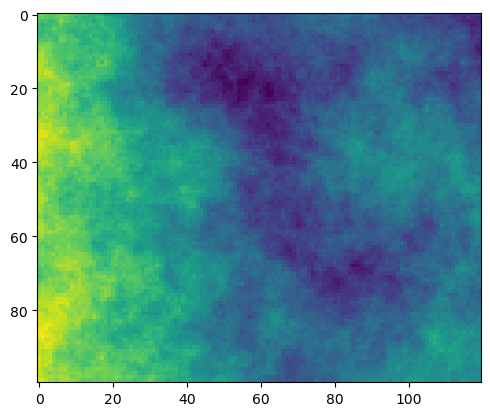

In [117]:
plt.imshow(cran)

(array([ 227., 1130., 2147., 2667., 1863., 1173., 1117., 1010.,  553.,
         113.]),
 array([-1.21259626, -0.84546159, -0.47832691, -0.11119224,  0.25594243,
         0.62307711,  0.99021178,  1.35734646,  1.72448113,  2.09161581,
         2.45875048]),
 <BarContainer object of 10 artists>)

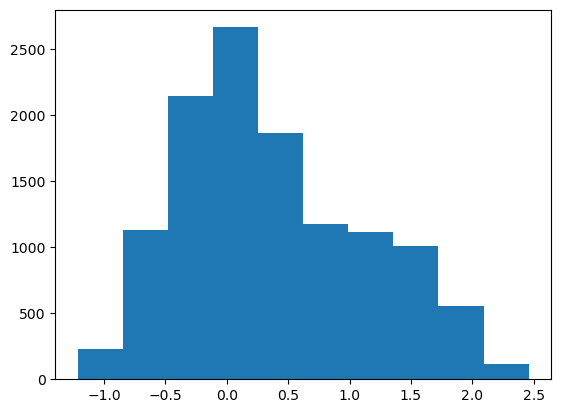

In [118]:
plt.hist(cran.flatten())

In [128]:
spcorr_wght[10,10].shape

(24,)

In [131]:
np.savez_compressed('test.npz',spcorr_wght=spcorr_wght)


In [146]:
dd=np.load('test.npz', allow_pickle=True)

In [148]:
dd['spcorr_wght'].shape

(100, 120)

In [155]:
import os


In [167]:
random.seed(10)

random_data = os.urandom(4) 
seed = int.from_bytes(random_data, byteorder="big")
seed

1273186309

In [205]:
for i in range(1):
    np.random.seed(i)
    rn = np.random.randint(0, 10000000, 10)
    print(rn)
    print('#'*50)
    for j in range(3):
        np.random.seed(rn[j])
        print(np.random.randint(0, 10000000, 2))

[8325804 1484405 2215104 5157699 8222403 7644169 5853461 6739698  374564
 2832983]
##################################################
[7026296  897971]
[9854229 7448954]
[1998351 3533909]


In [232]:

np.random.normal(0,1)

-0.7200855607188968